# Bayesian analysis and Monte Carlo simulation
#### Computational Methods for Geoscience - EPS 400/522
#### Instructor: Eric Lindsey

---------

In [1]:
# some useful imports and settings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from ipywidgets import interactive
import datetime
import time
import scipy.optimize

# new this week - may need to install using whichever method works for your computer.
import emcee
import corner

# local import statements specific to our problem
# these import a python module file that should be in our folder, not a conda package
import fault_model
import geod_transform
import moment_tensor

%config InlineBackend.figure_format = 'retina' # better looking figures on high-resolution screens
# automatically reload modules when running, otherwise jupyter does not notice if our functions have changed
%load_ext autoreload
%autoreload 2

# Initialize random number generator
# why do this? by setting the same initial seed, we can guarantee the same results each time we run the notebook
# note, you may *not* want to do this if you want to get unpredictable results!
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)

# not used in this lab:
#import multiprocessing as mp
#import scipy.fft
#import cv2
#import netCDF4 as nc
#import scipy.signal

## Monte Carlo example - line fitting

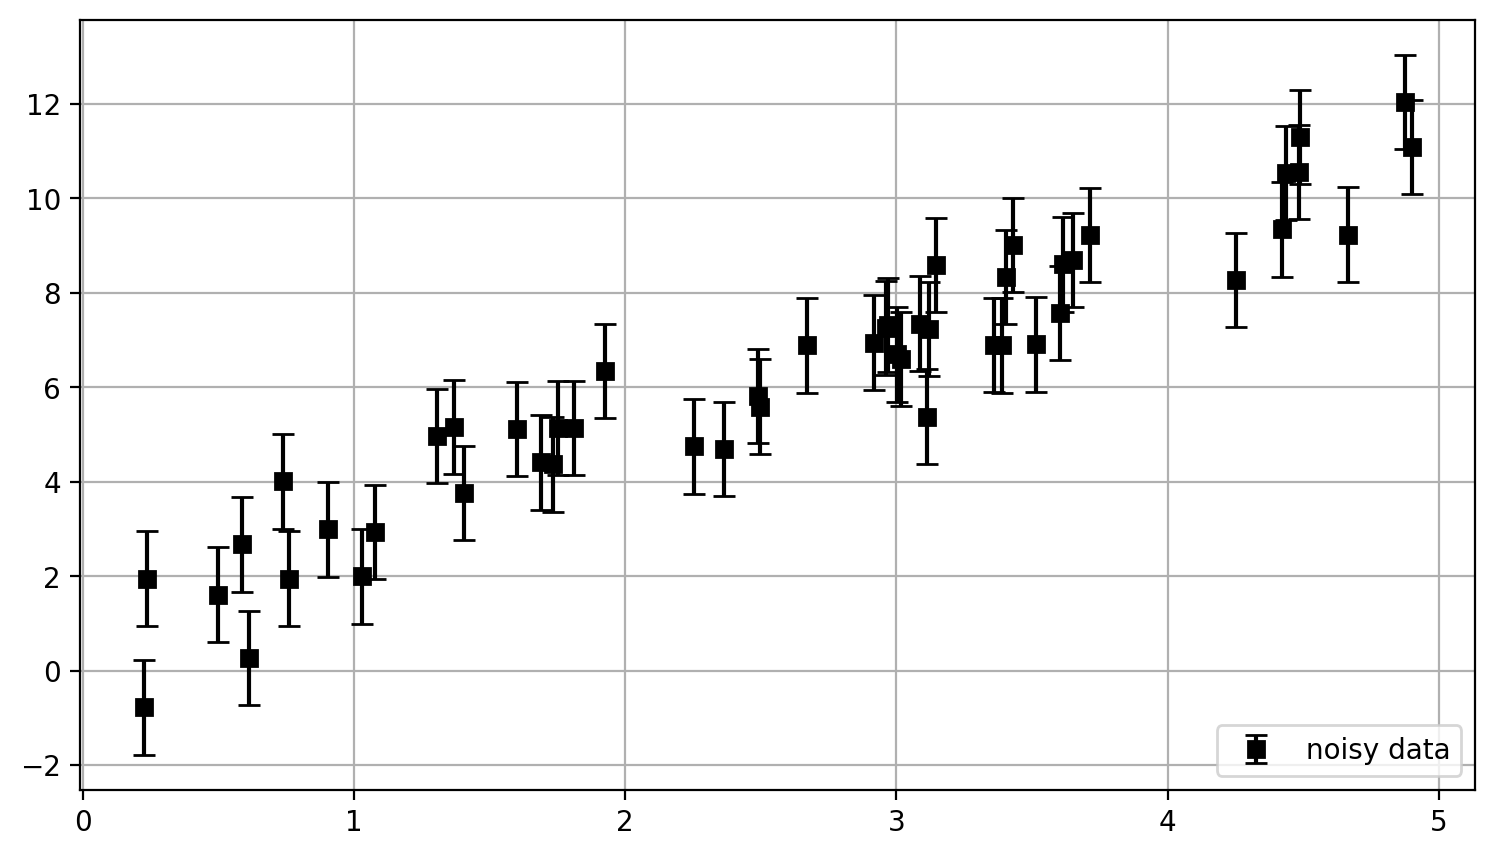

In [2]:
# create some test data that follows a line

# True parameter values
a_true = 1 
b_true = 2
sigma = 1

# Size of dataset
size = 50

# Predictor variable ("independent variable", or in geophysics, "coordinates")
x = 5*np.random.rand(size)

# Simulate outcome (dependent variable)
y = a_true + b_true * x + rng.normal(size=size) * sigma

# simulate y errors
yerr = sigma*np.ones(size)

# plot the simulated data
plt.figure(figsize=(9,5))
plt.errorbar(x,y,yerr=sigma,fmt='ks',label='noisy data',capsize=4)
plt.legend(loc='lower right')
plt.grid()
plt.show()


Since this is a 2-parameter, linear model, it's great for testing that our code is working, since we can benchmark it against the least squares solution. 

Benchmarking is always a good idea - don't try out your code on new data until you know for sure it works correctly!

### Solution 1. Least-squares analysis

Scipy curve_fit found: a,b = [0.87589935 2.05935958]
The true values were:  [1.00000000 2.00000000]
Covariances:
 [[ 0.08218903 -0.02517872]
 [-0.02517872  0.00975557]]


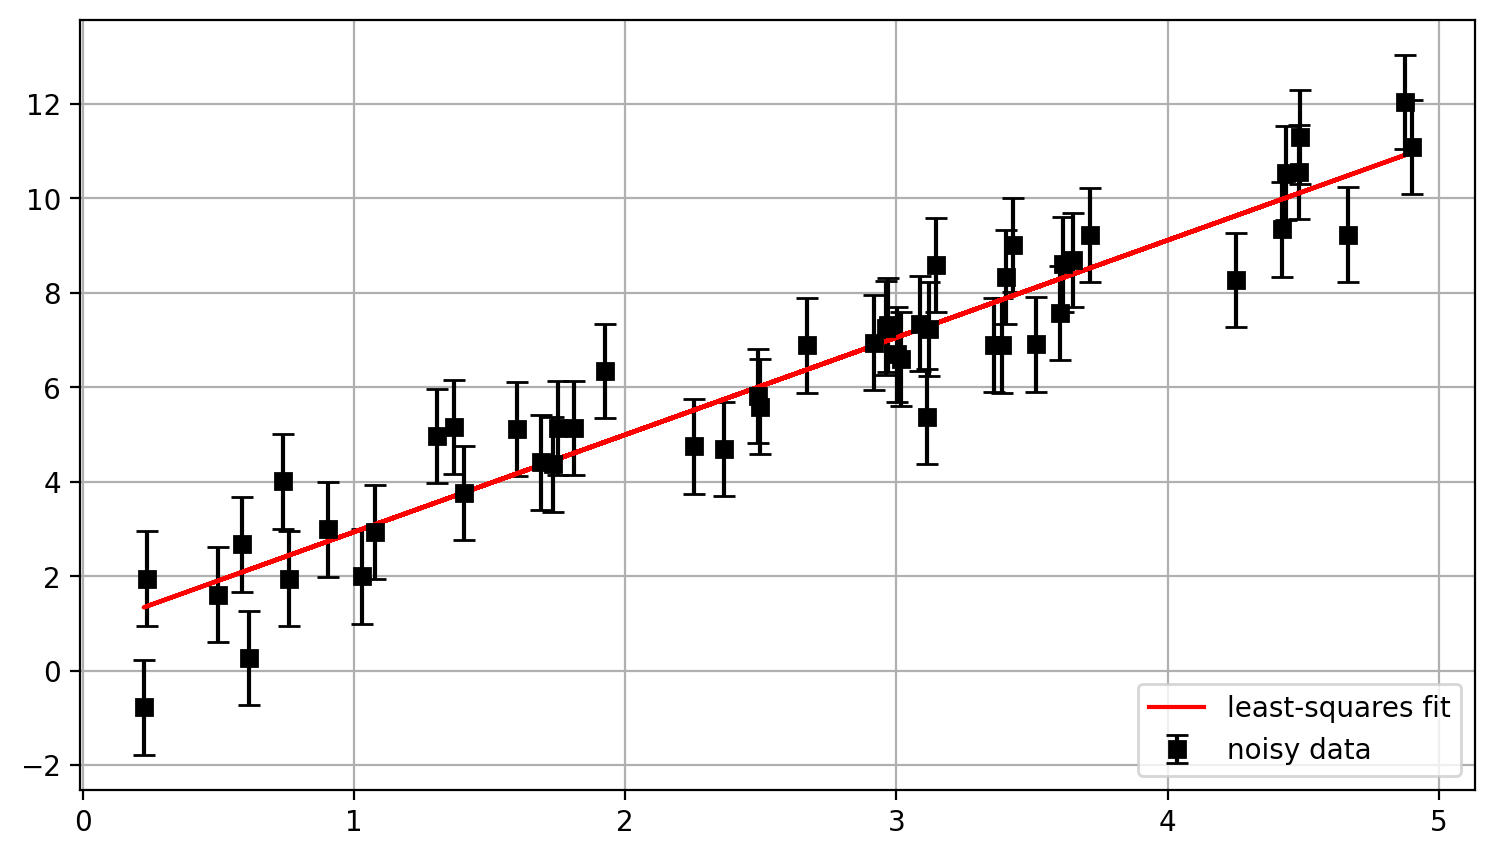

In [3]:
# define our model here - in this case, just a line. 
def model_line(x,*params):
    # this first line "unpacks" the list [params] into elements. 
    # An easier way to pass many variables to a function.
    alpha,beta = params
    # Compute the model, and return the y values
    model = alpha + beta*x
    return model

# here, p0 is the 'initial guess' for this method. 
# m is the model output, and mcov is the model covariance, or uncertainties.
m,mcov = scipy.optimize.curve_fit(model_line,x,y,p0=[0,0])
print('Scipy curve_fit found: a,b =',m)
print('The true values were:  [%.8f %.8f]'%(a_true,b_true))
print('Covariances:\n',mcov)

# to get the predicted y-values, we can just call our function my_line with the 
# model parameters determined by scipy.

# Note: we introduce a special python concept here called "unpacking" a list - when we write *m,
# this sends each of the elements of the list 'm' as separate arguments to the function.
lsq_model = model_line(x,*m) 
# so the above line is equivalent to:
# y_predicted = my_line(x,m[0],m[1])

plt.figure(figsize=(9,5))
plt.errorbar(x,y,yerr=sigma,fmt='ks',label='noisy data',capsize=4)
plt.plot(x,lsq_model, '-r', label='least-squares fit')
plt.legend(loc='lower right')
plt.grid()
plt.show()

### Solution 2. Monte carlo sampling

To run a monte carlo sampler, we need to define several funtions in addition to our "model" (defined above).

These are the log-likelihood (misfit), log-prior, and their combination

In [4]:
# "log likelihood" function for the sampler
def lnlike_line(params, x, y, yerr):
    # get the predicted model values
    ypred = model_line(x, *params)
    # compute the (negative) misfit - sum of the residuals squared, scaled by the data uncertainties
    misfit = -0.5*np.sum(((y-ypred)/yerr)**2)
    return misfit

# set our priors - we use this to set bounds on the parameters.
# return value is set to negative infinity if any parameters are outside their bounds, otherwise it is zero. 
# this is because we have taken the log() of our probability distribution. So 10^0 = 1, while 10^-np.inf = 0.
# if we wanted gaussian priors, or other types, we could also implement them here instead of bounds.
def lnprior_line(params):
    # define bounds here
    minvals = np.array([-10,-10])
    maxvals = np.array([10,10])
    if any(params-minvals<0) or any(params-maxvals>0): # check if any bounds are exceeded
        return -np.inf
    else:
        return 0.0
    
#finally, this function puts together all the above, to determine the actual log(probability) of a set of parameters.
def lnprob_line(params, x, y, yerr):
    prior = lnprior_line(params)
    if np.isinf(prior):
        return -np.inf
    else:
        return prior + lnlike_line(params, x, y, yerr) #recall if lp not -inf, its 0, so this just returns likelihood
    

### Next: run the sampler

In [5]:
# collect our variables to feed this function:
# 1. package our input x,y,yerr data together:
data = (x,y,yerr)

# 2. decide the number of random walks and how many steps in each one:
nwalkers = 50
niter = 1000

# 3. set initial guesses for each random walk
initial=[0,0]
# use this code to set up initial points for each random walk that are slightly different from each other
ndim = len(initial)
p0 = [np.array(initial) + 1e-1 * np.random.randn(ndim) for i in range(nwalkers)]

# create the sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob_line, args=data)

# start the timer
tstart = time.time()

# run some initial steps to discard, so the walkers get into a reasonable starting location
print("Running burn-in...")
p0, _, _ = sampler.run_mcmc(p0, niter)
sampler.reset()

print("Running production...")
pos, prob, state = sampler.run_mcmc(p0, niter)

# end the timer
tend = time.time()
print("Done! Sampling took %f seconds." %(tend-tstart))



Running burn-in...
Running production...
Done! Sampling took 2.997585 seconds.


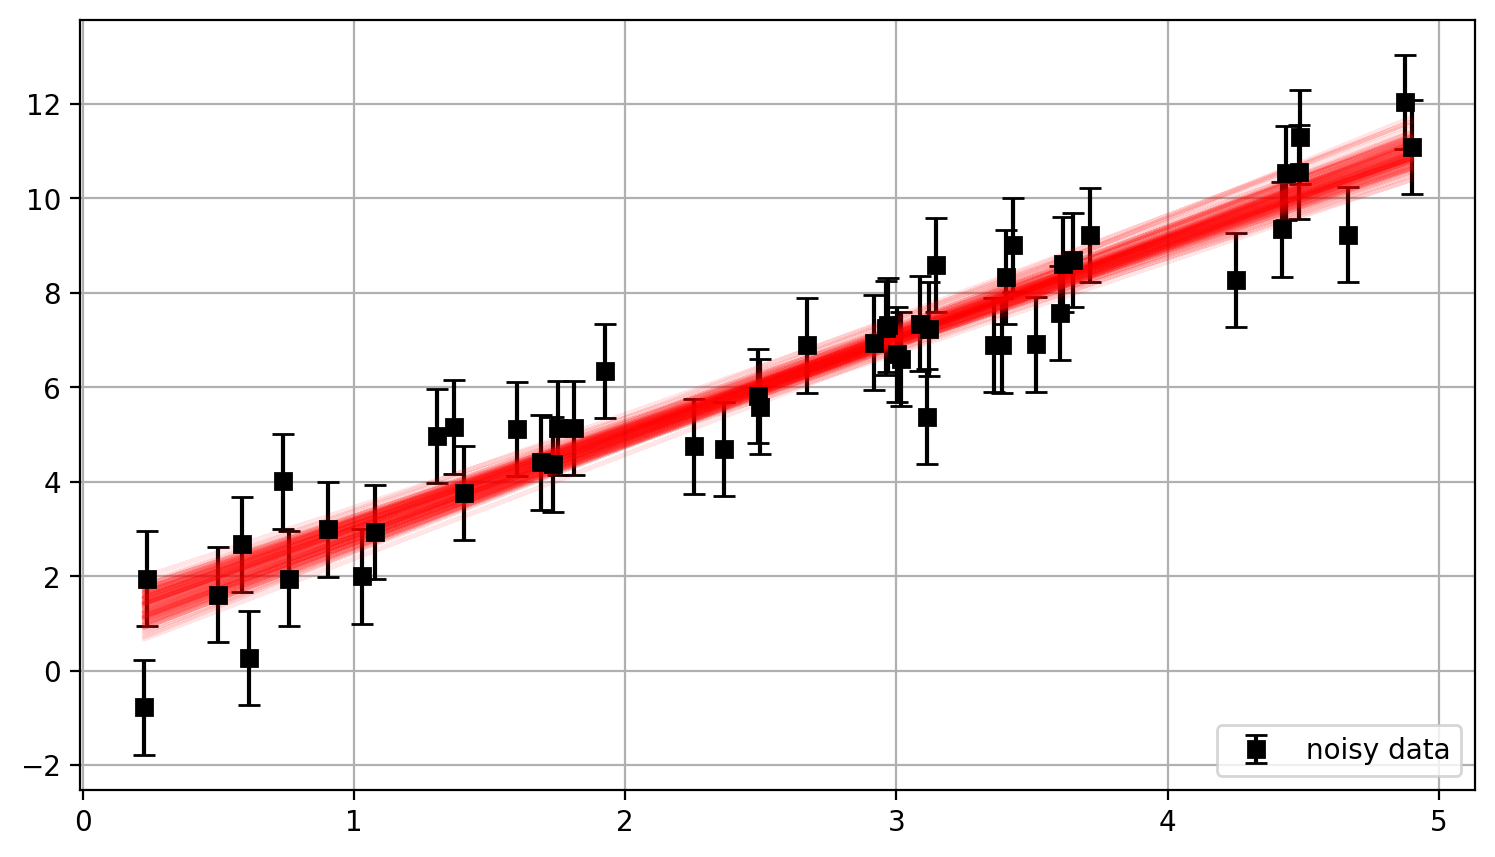

In [6]:
# plot some of the samples, selected at random
samples = sampler.flatchain

plt.figure(figsize=(9,5))
plt.errorbar(x,y,yerr=sigma,fmt='ks',label='noisy data',capsize=4)
for params in samples[np.random.randint(len(samples), size=100)]: # plot 100 random samples
    plt.plot(x, model_line(x,*params), color="r", alpha=0.1)
plt.legend(loc='lower right')
plt.grid()
plt.show()

MCMC Best fit:  [0.87330265 2.06062846]
LSQ Best fit:  [0.87589935 2.05935958]


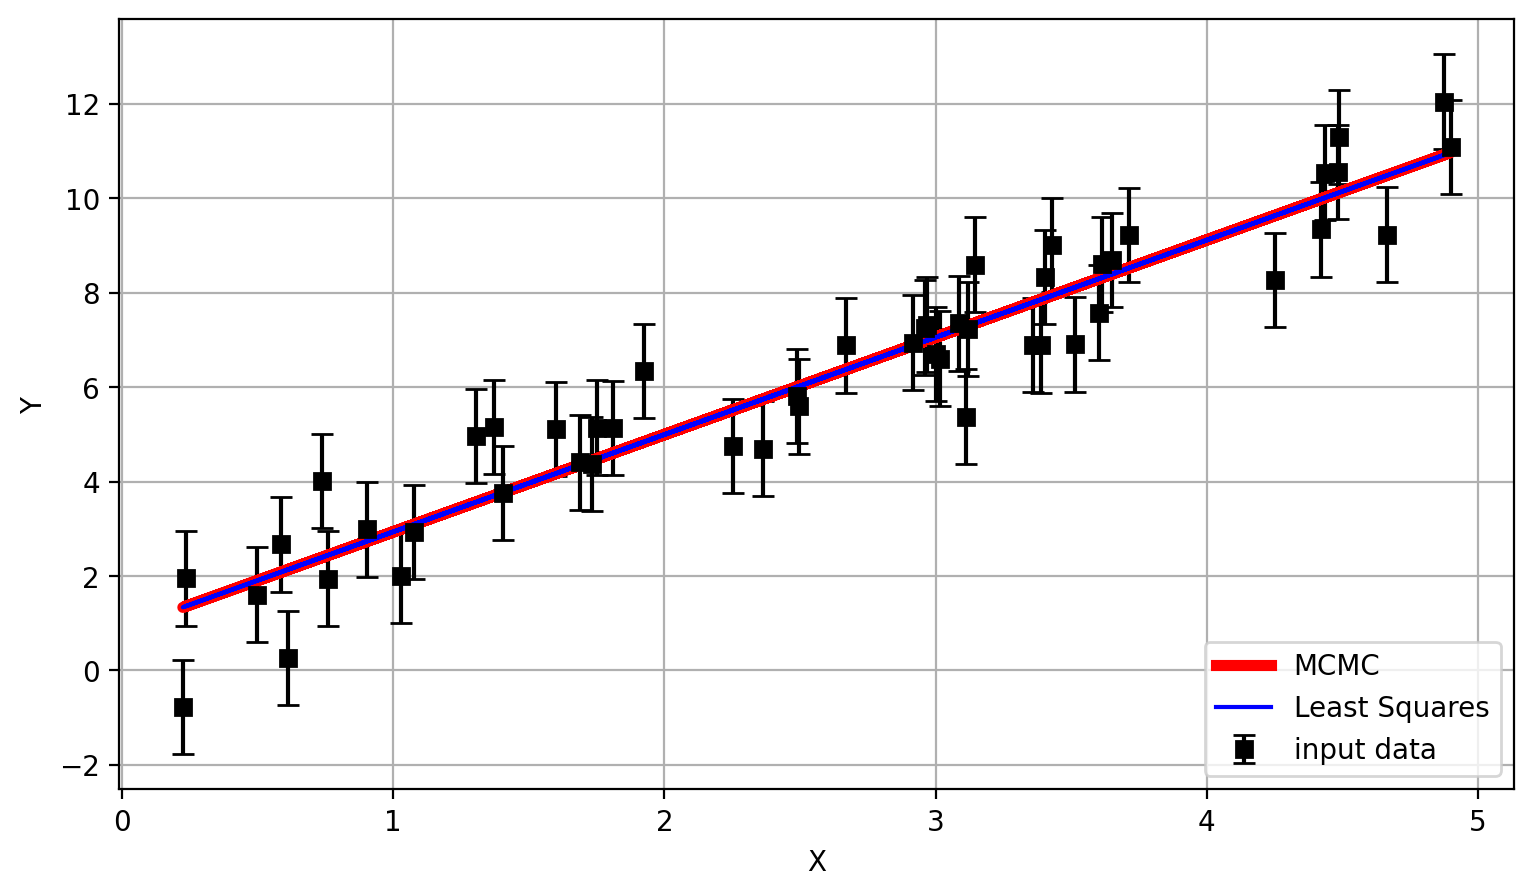

In [7]:
# plot the best fitting sample
# np.argmax finds the location of the maximum element in an array.
# so samples[np.argmax(sampler.flatlnprobability)] finds the location in the chain with the maximum log-likelihood,
# and then returns the model that has that likelihood
params_max  = samples[np.argmax(sampler.flatlnprobability)]
print('MCMC Best fit: ',params_max)
print('LSQ Best fit: ',m) 

# compute the line model for this set of parameters
best_fit_model = model_line(x,*params_max)

plt.figure(figsize=(9,5))
plt.errorbar(x,y,yerr=sigma,fmt='ks',label='input data',capsize=4)
plt.plot(x, best_fit_model,'-r',label="MCMC",linewidth=4)
plt.plot(x, lsq_model, '-b',label='Least Squares')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xlabel('X')
plt.ylabel('Y')
plt.grid()
plt.legend(loc='lower right')
plt.show()


### Plot the distribution of the samples for each parameter
Laying out all the subplots to make a plot of all the 1D and 2D marginal PDFs would be kind of painful. We use the `corner` python library that makes this quick and easy. Note that all we are passing to it is the MxN array containing the M samples in N dimensions. There is lots more in the documentation: https://corner.readthedocs.io/en/latest/api/


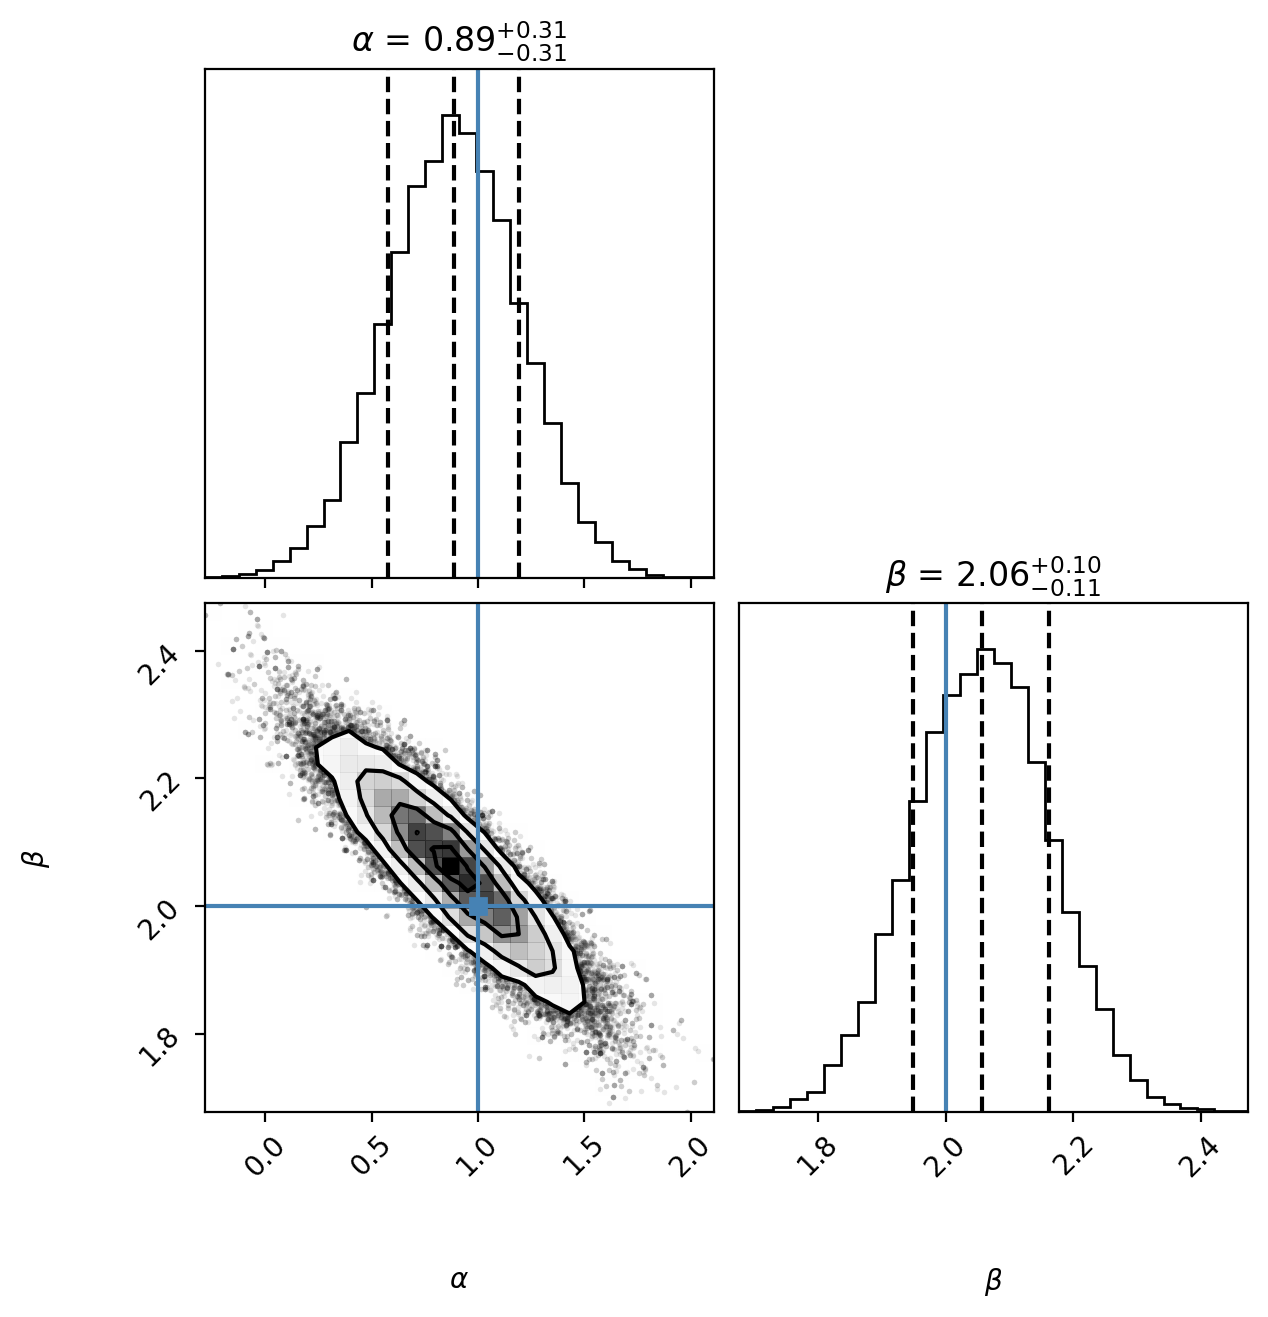

In [8]:
# plot the PDFs of the samples
labels = [r'$\alpha$',r'$\beta$'] # this special r'$ $' format allows greek lettering or other LaTeX commands in the plot.
myFig=plt.figure(figsize=(7,7))

# lots of options to make this plot nice. Try playing around with some!
fig = corner.corner(samples,show_titles=True,bins=30,use_math_text=True,fig=myFig,labels=labels,plot_datapoints=True,
                    quantiles=[0.16, 0.5, 0.84],truths=[1,2])

In the above plot, notice that the blue line (the "true" parameters we used to generate the original data is not at the center of the probability distribution. What do you think this means?

## Example 2. Earthquake!

The case above was a good benchmark, but pretty boring and not that useful. Let's try fitting some GPS data from the Ridgecrest earthquake.

In [ ]:
# load GPS data
gpsdata = pd.read_csv('GPS_Ridgecrest.csv')

# I will convert them all to arrays at the start.
gpslon = np.asarray(gpsdata["X"])
gpslat = np.asarray(gpsdata["Y"])
gps_dE = np.asarray(gpsdata["E"])/100 # data are in cm, but we want meters
gps_dN = np.asarray(gpsdata["N"])/100

#the Ridgecrest data do not have vertical displacements measured, but our model needs them, so we set them to zero..
gps_dU = 0.*gps_dE

# create a single vector with the locations to pass to the function
gps_locations=np.append(gpslon,gpslat)

# we also create a single vector that has all the GPS data in it
# the layout of this vector is [E,N,U] for each point. For example, with n points:
#gps_displacements = [E1,N1,U1,E2,N2,U2,...,En,Nn,Un]
# for this, we need to know how many GPS points there are.
Ngps = np.size(gpslon)
# now, create a blank vector of the right length
gps_displacements=np.empty((3*Ngps,),dtype=float)
# fill it up, with indices representing every third item
gps_displacements[0::3] = gps_dE
gps_displacements[1::3] = gps_dN
gps_displacements[2::3] = gps_dU

# gps uncertainties - use fake estimates here
gps_err = 0.01*np.ones(np.size(gps_displacements))

# create a plot of the data
fig = plt.figure(figsize = (7,7))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlim([-119, -115.5])
ax.set_ylim([34.5, 37])
ax.grid()
ax.scatter(-117.599,35.770,marker='*',c='r',s=200,label='Epicenter')
vecscale = 1.5 # divide arrows by this number - larger number means smaller arrows
q = ax.quiver(gpslon,gpslat,gps_dE,gps_dN, scale=vecscale)
ax.quiverkey(q,X=0.85,Y=0.85,U=0.1, label ='10 cm')
plt.show()

In [ ]:
# create an example model and plot it with the data

latc = 35.73  # locations are in degrees lon/lat
lonc = -117.56
depthc = 5.5e3 # units of distances are in meters
strike = -40
dip = 67
L = 40e3
W = 11e3
strike_slip = -4   # negative means right-lateral
dip_slip = -0.5

# create the model
Fmod=fault_model.FaultModel()
Fmod.create_planar_model_centered(latc=latc,lonc=lonc,depthc=depthc,strike=strike,dip=dip,L=L,W=W,nL=1,nW=1)
# get the "G" matrix for our particular GPS site locations (lat,lon)
G=Fmod.get_greens(gpslat,gpslon)
# m is the slip
m = np.array([strike_slip,dip_slip])
# predict GPS displacements with d=G*m
predicted_displacements = np.matmul(G,m)

print('misfit:',0.5*np.sum(((gps_displacements-predicted_displacements)/gps_err)**2))

pred_E = predicted_displacements[0::3]
pred_N = predicted_displacements[1::3]

fig = plt.figure(figsize = (7,7))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlim([-119, -115.5])
ax.set_ylim([34.5, 37])
ax.grid()
ax.scatter(-117.599,35.770,marker='*',c='r',s=200,label='Epicenter')
vecscale = 1.5 # divide arrows by this number - larger number means smaller arrows
q1 = ax.quiver(gpslon,gpslat,gps_dE,gps_dN, scale=vecscale)
q2 = ax.quiver(gpslon,gpslat,pred_E,pred_N, scale=vecscale,color='red')
ax.quiverkey(q1,X=0.85,Y=0.85,U=0.1, label ='10 cm')
ax.quiverkey(q1,X=0.85,Y=0.93,U=0.1, label ='model',color='red')
plt.show()

mag=moment_tensor.get_magnitude(L,W,np.sqrt(strike_slip**2+dip_slip**2)) # seismic moment is proportional to area * slip
print('predicted magnitude is %.1f'%mag)

In [ ]:
# define our fault modeling function for the sampler to fit.
def fault_model_for_fitting(gps_locs,*params):
    # expand the '[params]' list into its elements
    latc,lonc,depthc,strike,dip,L,W,ss,ds = params
    # for the modeling, we need the locations as x and y, not a single vector
    Ngps=int(np.size(gps_locs)/2)
    gpslon=gps_locs[:Ngps]
    gpslat=gps_locs[Ngps:]
    # create the model
    Fmod=fault_model.FaultModel()
    Fmod.create_planar_model_centered(latc=latc,lonc=lonc,depthc=depthc*1e3,strike=strike,dip=dip,L=L*1e3,W=W*1e3,nL=1,nW=1)
    # get the "G" matrix for our particular GPS site locations (lat,lon)
    G=Fmod.get_greens(gpslat,gpslon)
    # m is the slip
    m = np.array([ss,ds])
    # predict GPS displacements with d=G*m
    predicted_displacements = np.matmul(G,m)                                  
    # return the predicted values
    return predicted_displacements


# "log likelihood" function for the sampler
def lnlike_fault(params, x, y, yerr):
    # get the predicted model values
    ypred = fault_model_for_fitting(x, *params)
    # compute the (negative) misfit - sum of the residuals squared, scaled by the data uncertainties
    misfit = -0.5*np.sum(((y-ypred)/yerr)**2)
    return misfit

# set our priors - we use this to set bounds on the parameters.
# return value is set to negative infinity if any parameters are outside their bounds, otherwise it is zero. 
# this is because we have taken the log() of our probability distribution. So 10^0 = 1, while 10^-np.inf = 0.
# if we wanted gaussian priors, or other types, we could also implement them here instead of bounds.
def lnprior_fault(params):
    # define bounds here
    minvals = np.array([34.2,-118.5,0,-60,45,10,1,-10,-2])
    maxvals = np.array([37.2,-117,20,-20,135,200,50,10,2])
    if any(params-minvals<0) or any(params-maxvals>0): # check if any bounds are exceeded
        return -np.inf
    else:
        return 0.0
    
#finally, this function puts together all the above, to determine the actual log(probability) of a set of parameters.
def lnprob_fault(params, x, y, yerr):
    prior = lnprior_fault(params)
    if np.isinf(prior):
        return -np.inf
    else:
        return prior + lnlike_fault(params, x, y, yerr) #recall if lp not -inf, its 0, so this just returns likelihood
    

In [ ]:
# collect our variables to feed this function:
# 1. package our input x,y,yerr data together:
data = (gps_locations,gps_displacements,gps_err)

# 2. decide the number of random walks and how many steps in each one:
nwalkers = 20
niter = 2000

# 3. set initial guesses for each random walk
initial=[35.7306, -117.5587, 4.25, -40.94, 66.90, 33.36, 10.29, -4.13, -0.51]

# set up initial points for each random walk that are slightly different from each other
ndim = len(initial)
p0 = [np.array(initial) + 0.005 * np.random.randn(ndim) for i in range(nwalkers)]

# create the sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob_fault, args=data)

# start the timer
tstart = time.time()

# run some initial steps to discard, so the walkers get into a reasonable starting location
print("Running burn-in...")
p0, _, _ = sampler.run_mcmc(p0, 50)
sampler.reset()

print("Running production...")
pos, prob, state = sampler.run_mcmc(p0, niter)

# end the timer
tend = time.time()
print("Done! Sampling took %f seconds." %(tend-tstart))



In [ ]:
samples = sampler.flatchain
params_max  = samples[np.argmax(sampler.flatlnprobability)]
print('%.4f, %.4f, %.2f, %.2f, %.2f, %.2f, %.2f, %.2f, %.2f'%tuple(params_max))
predicted_displacements = fault_model_for_fitting(gps_locations,*params_max)
pred_E = predicted_displacements[0::3]
pred_N = predicted_displacements[1::3]

fig = plt.figure(figsize = (7,7))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlim([-119, -115.5])
ax.set_ylim([34.5, 37])
ax.grid()
ax.scatter(-117.599,35.770,marker='*',c='r',s=200,label='Epicenter')
vecscale = 1.5 # divide arrows by this number - larger number means smaller arrows
q1 = ax.quiver(gpslon,gpslat,gps_dE,gps_dN, scale=vecscale)
q2 = ax.quiver(gpslon,gpslat,pred_E,pred_N, scale=vecscale,color='red')
ax.quiverkey(q1,X=0.85,Y=0.85,U=0.1, label ='10 cm')
ax.quiverkey(q1,X=0.85,Y=0.93,U=0.1, label ='model',color='red')
plt.show()


In [ ]:
labels = ['lat','lon','depth','strike','dip','len','wid','ss','ds']
myFig=plt.figure(figsize=(14,14))
fig = corner.corner(samples,show_titles=True,bins=20,use_math_text=True,fig=myFig,
                    labels=labels,plot_datapoints=True,quantiles=[0.16, 0.5, 0.84])

## Bonus: more advanced sampling

The MCMC sampling method we are using, implemented by the `emcee` package, is called an "Ensemble Metropolis Hastings sampler", and is described by Goodman & Weare (2010), http://dx.doi.org/10.2140/camcos.2010.5.65. The 'ensemble' nature of this sampler means it samples along multiple random walks simultaneously, and uses the information contained in the combination of their present locations to sample more efficiently - neatly avoiding the issues related to slow sampling in highly-correlated distributions that we discussed in class.

However, we know that the Metropolis Hastings approach still leads to relatively slow convergence because the steps tend to be small, at least compared to slice sampling. If we could use an ensemble slice sampler, perhaps that would be the best of both worlds? Fortunately, such a method has been recently developed by Karamanis & Beutler (2021), https://dx.doi.org/10.1007/s11222-021-10038-2, and we can use it with the `zeus` package in Python, which follows roughly the same structure of `emcee`. 

Try installing this package and re-implement one of the two sampling codes above using that sampler, and make a comparison. How much faster is it? Can you get a similar-looking distribution with fewer samples?

In [ ]:
import zeus

# collect our variables to feed this function:
# 1. package our input x,y,yerr data together:
data = (gps_locations,gps_displacements,gps_err)

# 2. decide the number of random walks and how many steps in each one:
nwalkers = 20
niter = 500

# 3. set initial guesses for each random walk
initial=[35.7306, -117.5587, 4.25, -40.94, 66.90, 33.36, 10.29, -4.13, -0.51]
# use this code to set up initial points for each random walk that are slightly different from each other
ndim = len(initial)
p0 = [np.array(initial) + 0.005 * np.random.randn(ndim) for i in range(nwalkers)]

# create the sampler
zsampler = zeus.EnsembleSampler(nwalkers, ndim, lnprob_fault, args=data)

# start the timer
tstart = time.time()

# zeus will automatically tune the sampler
print("Running sampling...")
zsampler.run_mcmc(p0, niter)
zsampler.summary # Print summary diagnostics

# end the timer
tend = time.time()
print("Done! Sampling took %f seconds." %(tend-tstart))


In [ ]:
zsamples = zsampler.get_chain(flat=True)
params_max  = zsamples[np.argmax(zsampler.get_log_prob())]
print('%.2f, %.2f, %.2f, %.2f, %.2f, %.2f, %.2f, %.2f, %.2f'%tuple(params_max))
predicted_displacements = fault_model_for_fitting(gps_locations,*params_max)
pred_E = predicted_displacements[0::3]
pred_N = predicted_displacements[1::3]

fig = plt.figure(figsize = (7,7))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlim([-119, -115.5])
ax.set_ylim([34.5, 37])
ax.grid()
ax.scatter(-117.599,35.770,marker='*',c='r',s=200,label='Epicenter')
vecscale = 1.5 # divide arrows by this number - larger number means smaller arrows
q1 = ax.quiver(gpslon,gpslat,gps_dE,gps_dN, scale=vecscale)
q2 = ax.quiver(gpslon,gpslat,pred_E,pred_N, scale=vecscale,color='red')
ax.quiverkey(q1,X=0.85,Y=0.85,U=0.1, label ='10 cm')
ax.quiverkey(q1,X=0.85,Y=0.93,U=0.1, label ='model',color='red')
plt.show()


In [ ]:
plt.plot(zsampler.get_log_prob())
plt.ylim(-200,0)
plt.show()

In [ ]:
labels = ['lat','lon','depth','strike','dip','len','wid','ss','ds']
myFig=plt.figure(figsize=(14,14))
fig = corner.corner(zsamples,show_titles=True,bins=20,use_math_text=True,fig=myFig,labels=labels,plot_datapoints=True,quantiles=[0.16, 0.5, 0.84])